In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"gurramsravani","key":"df139dc2e1c82955ffaed55c90f496c1"}'}

In [2]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!ls

sample_data


In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("salviohexia/isic-2019-skin-lesion-images-for-classification")

print("Path to dataset files:", path)

100%|██████████| 9.10G/9.10G [07:36<00:00, 21.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/salviohexia/isic-2019-skin-lesion-images-for-classification/versions/1


In [5]:
!ls

sample_data


In [6]:
!mv /root/.cache/kagglehub/datasets/salviohexia/isic-2019-skin-lesion-images-for-classification/versions/1 /content/

In [7]:
!ls /content/1/

AK   BKL  ISIC_2019_Training_GroundTruth.csv  MEL  SCC
BCC  DF   ISIC_2019_Training_Metadata.csv     NV   VASC


In [8]:
!mv /content/1 /content/skin-disease-dataset

In [9]:
!ls

sample_data  skin-disease-dataset


In [10]:
!ls /content/skin-disease-dataset/

AK   BKL  ISIC_2019_Training_GroundTruth.csv  MEL  SCC
BCC  DF   ISIC_2019_Training_Metadata.csv     NV   VASC


In [11]:
# General and Data Libraries
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from collections import Counter

# Image Processing
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

# Model Building
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Data Balancing
from imblearn.over_sampling import RandomOverSampler

# Visualization Style
sns.set_style('darkgrid')
warnings.filterwarnings("ignore")

In [12]:
# Load metadata
data = pd.read_csv('/content/skin-disease-dataset/ISIC_2019_Training_GroundTruth.csv')
print("Data Shape:", data.shape)

# Check image folder structure
dataset_path = '/content/skin-disease-dataset'
print(os.listdir(dataset_path))

Data Shape: (25331, 10)
['BKL', 'AK', 'MEL', 'DF', 'ISIC_2019_Training_GroundTruth.csv', 'BCC', 'ISIC_2019_Training_Metadata.csv', 'VASC', 'NV', 'SCC']


In [13]:
def load_and_resize_images(image_paths, target_size=(28, 28)):
    images = []
    for path in image_paths:
        img = load_img(path, target_size=target_size)  # Load and resize
        img_array = img_to_array(img)  # Convert to array
        images.append(img_array)
    return np.array(images)


In [14]:
# Define classes
class_folders = ['MEL', 'VASC', 'SCC', 'DF', 'NV', 'BKL', 'BCC', 'AK']

# Load images and labels
all_images, all_labels = [], []

for class_name in class_folders:
    class_folder_path = os.path.join(dataset_path, class_name)
    image_files = os.listdir(class_folder_path)
    class_images = load_and_resize_images([os.path.join(class_folder_path, img) for img in image_files])
    all_images.append(class_images)
    all_labels.append([class_name] * len(image_files))

# Combine all data
X_all = np.concatenate(all_images, axis=0)
y_all = np.concatenate(all_labels, axis=0)

print("Shape of all images:", X_all.shape)
print("Shape of all labels:", y_all.shape)


Shape of all images: (25331, 28, 28, 3)
Shape of all labels: (25331,)


In [15]:
# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_all)
y_one_hot = to_categorical(y_encoded)

# Reshape data for oversampling
X_reshaped = X_all.reshape(X_all.shape[0], -1)
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X_reshaped, y_one_hot)

print("Class distribution after oversampling:", Counter(np.argmax(y_resampled, axis=1)))

Class distribution after oversampling: Counter({np.int64(4): 12875, np.int64(7): 12875, np.int64(6): 12875, np.int64(3): 12875, np.int64(5): 12875, np.int64(2): 12875, np.int64(1): 12875, np.int64(0): 12875})


In [16]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
print(f"Shapes - X_train: {X_train.shape}, X_test: {X_test.shape}, y_train: {y_train.shape}, y_test: {y_test.shape}")

Shapes - X_train: (82400, 2352), X_test: (20600, 2352), y_train: (82400, 8), y_test: (20600, 8)


In [17]:
# Reshape to (28, 28, 3)
X_train_reshaped = X_train.reshape(X_train.shape[0], 28, 28, 3)
X_test_reshaped = X_test.reshape(X_test.shape[0], 28, 28, 3)

In [18]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.01), input_shape=(28, 28, 3)),
    MaxPooling2D(),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.01)),
    MaxPooling2D(),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.01)),
    MaxPooling2D(),
    BatchNormalization(),
    Flatten(),
    Dropout(0.5),
    Dense(256, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dense(128, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dense(64, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dense(8, activation='softmax')
])


In [19]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]

history = model.fit(X_train_reshaped, y_train, validation_data=(X_test_reshaped, y_test), epochs=70, batch_size=64, callbacks=callbacks)

Epoch 1/70
1288/1288 ━━━━━━━━━━━━━━━━━━━━ 26s 11ms/step - accuracy: 0.4224 - loss: 7.6981 - val_accuracy: 0.4155 - val_loss: 2.3857 - learning_rate: 0.0010
Epoch 2/70
1288/1288 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.5841 - loss: 1.9493 - val_accuracy: 0.3896 - val_loss: 2.6311 - learning_rate: 0.0010
Epoch 3/70
1288/1288 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6228 - loss: 1.7999 - val_accuracy: 0.5626 - val_loss: 1.9609 - learning_rate: 0.0010
Epoch 4/70
1288/1288 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.6414 - loss: 1.7366 - val_accuracy: 0.5855 - val_loss: 1.8688 - learning_rate: 0.0010
Epoch 5/70
1288/1288 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.6598 - loss: 1.6574 - val_accuracy: 0.4414 - val_loss: 2.4117 - learning_rate: 0.0010
Epoch 6/70
1288/1288 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.6758 - loss: 1.6010 - val_accuracy: 0.6108 - val_loss: 1.7313 - learning_rate: 0.0010
Epoch 7/70
1288/1288 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.6839

In [21]:

import matplotlib.pyplot as plt
import numpy as np

# Plotting Training and Validation Metrics
def plot_training(hist):
    # Extracting accuracy and loss values
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']

    # Finding the best epochs for loss and accuracy
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    # Plot settings
    plt.figure(figsize=(20, 8))
    plt.style.use('fivethirtyeight')
    epochs = [i + 1 for i in range(len(tr_acc))]
    loss_label = f'Best Epoch = {index_loss + 1}'
    acc_label = f'Best Epoch = {index_acc + 1}'

    # Plotting Training and Validation Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, tr_loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'g', label='Validation Loss')
    plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting Training and Validation Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, tr_acc, 'r', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'g', label='Validation Accuracy')
    plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


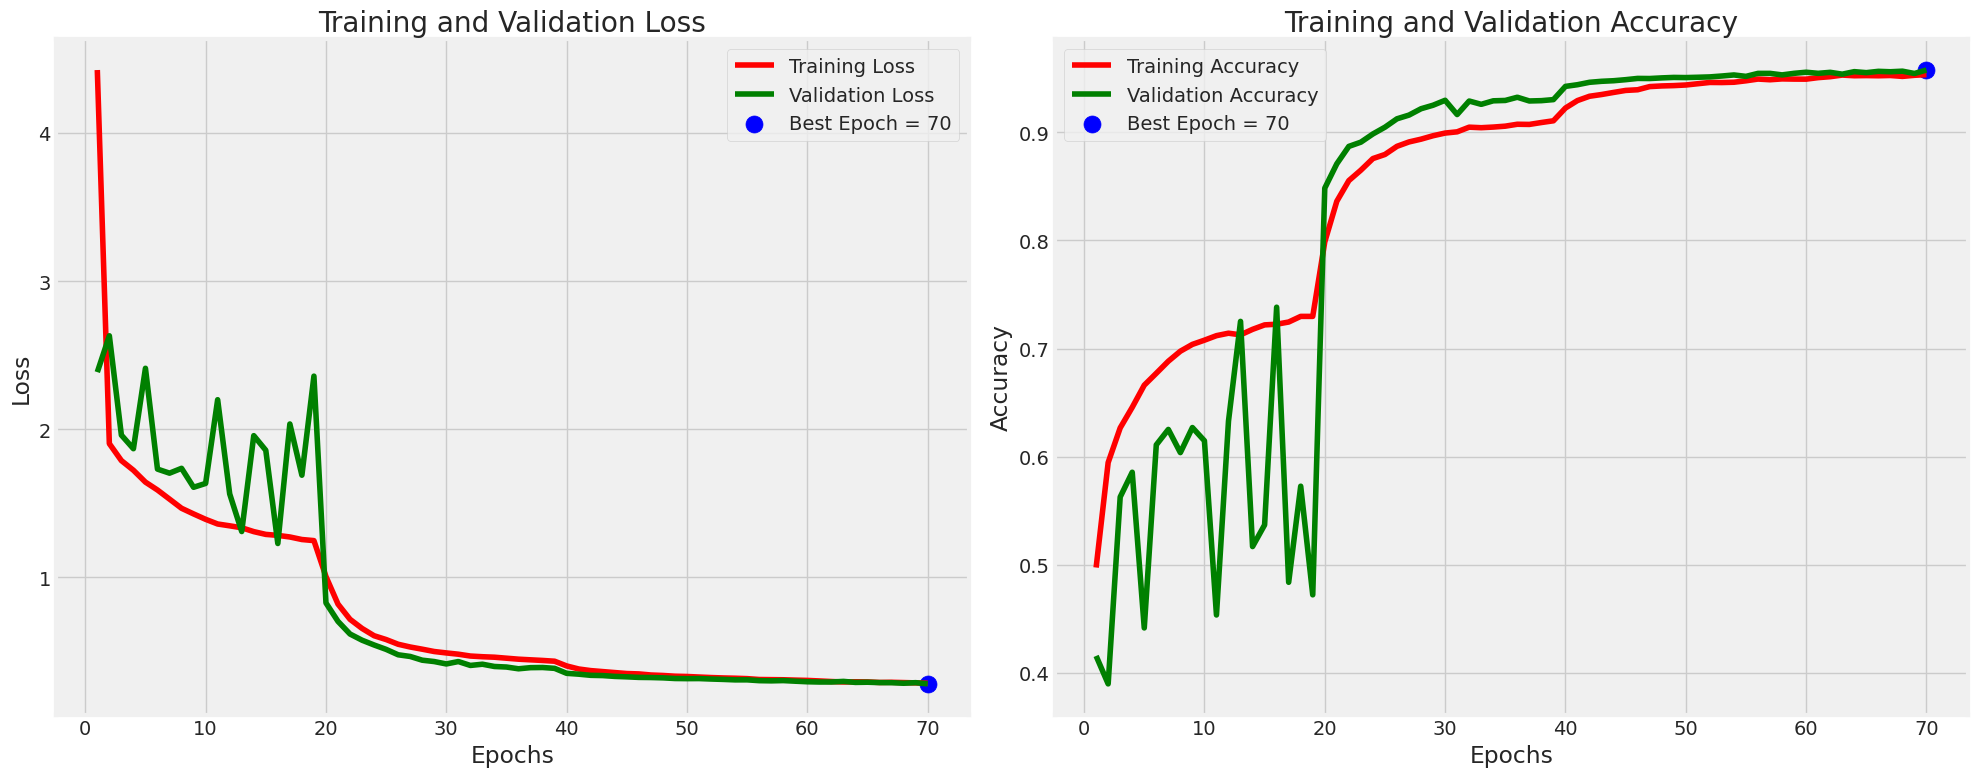

In [22]:
plot_training(history)

In [23]:
test_loss, test_accuracy = model.evaluate(X_test_reshaped, y_test, verbose=1)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


644/644 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9591 - loss: 0.2792
Test Accuracy: 95.77%
Test Loss: 0.2817


644/644 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
              precision    recall  f1-score   support

          AK       0.99      1.00      1.00      2582
         BCC       0.95      0.99      0.97      2665
         BKL       0.94      0.98      0.96      2582
          DF       1.00      1.00      1.00      2517
         MEL       0.89      0.90      0.89      2612
          NV       0.90      0.80      0.85      2557
         SCC       1.00      1.00      1.00      2550
        VASC       1.00      1.00      1.00      2535

    accuracy                           0.96     20600
   macro avg       0.96      0.96      0.96     20600
weighted avg       0.96      0.96      0.96     20600



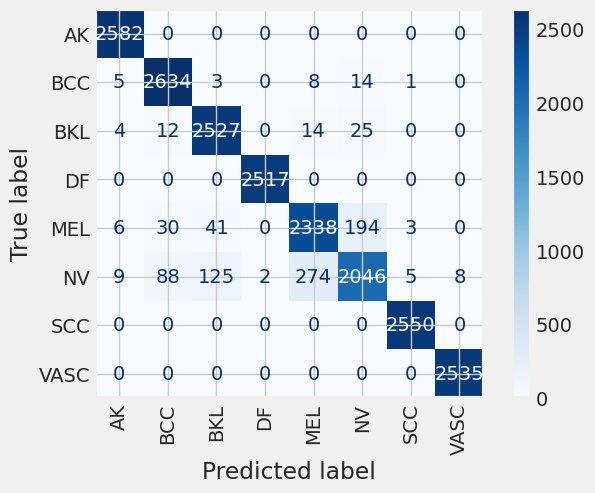

In [24]:
y_pred = np.argmax(model.predict(X_test_reshaped), axis=1)
y_true = np.argmax(y_test, axis=1)

print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.show()


In [25]:
model.save("skin_cnn.h5")

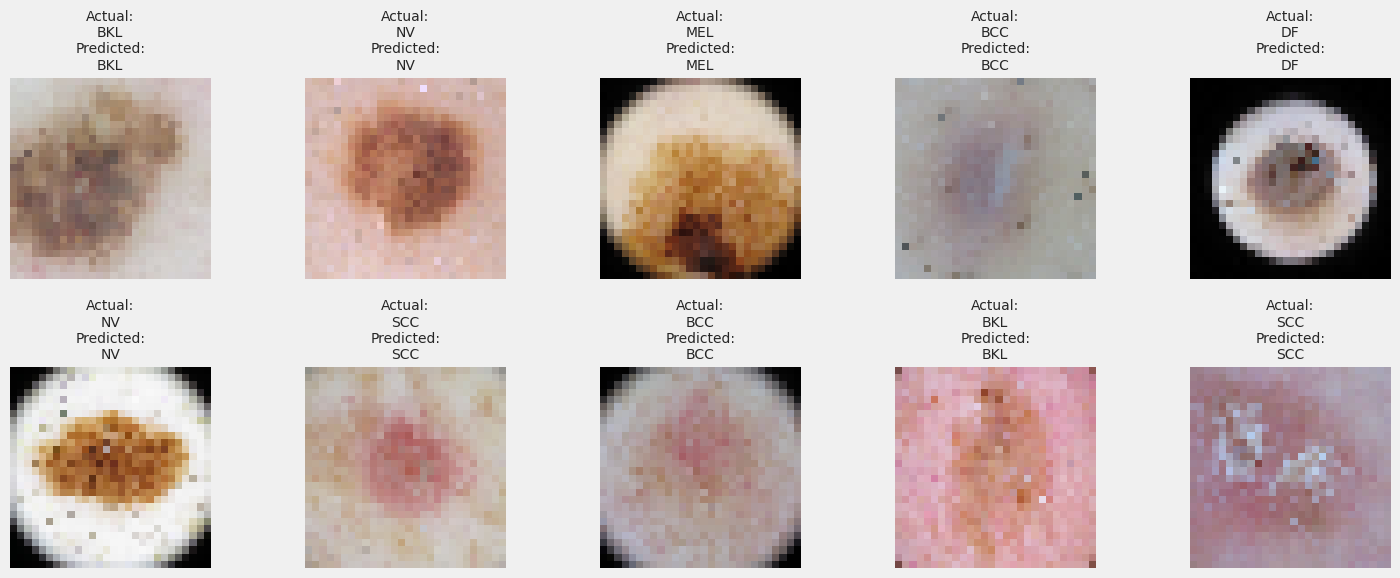

In [41]:
import random
import matplotlib.pyplot as plt
import math

# Number of images to display
num_samples = 10
images_per_row = 5

# Select random test images
random_indices = random.sample(range(len(X_test_reshaped)), num_samples)

# Calculate number of rows needed
num_rows = math.ceil(num_samples / images_per_row)

plt.figure(figsize=(15, 3 * num_rows))  # Adjust figure size dynamically

for i, idx in enumerate(random_indices):
    img = X_test_reshaped[idx]  # Get test image
    true_label = label_encoder.classes_[y_true[idx]]  # Actual class
    predicted_label = label_encoder.classes_[y_pred[idx]]  # Predicted class

    plt.subplot(num_rows, images_per_row, i + 1)
    plt.imshow(img.astype("uint8"))
    plt.axis('off')
    plt.title(f"Actual:\n{true_label}\nPredicted:\n{predicted_label}", fontsize=10)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()
